# Support Vector Machine - Daily Taxi Demand Prediction

In this section we predict the daily demand of taxi trips in Chicago. 
The prediciton we perform by building a model are based on data from 2013, provided from Chicago (website: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

We split the prediction into spatial units:
- Community Areas
- hexagons with low resolution
- hexagons with medium resolution
- hexagons with high resolution

For each of the units we perform a seperate prediction based on data we have aggregeated in our preparation.

For that we proceed as follows:

- Build SVM model with different kernels to find out which performs best. We do this based on Community areas.
- Hyperparameter tuning to find the best ones
- Build the model with found kernel and hyperparameters: make predictions for all spatial units
- Evaluation

<hr style="border: 1px solid #8888;">

In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn import datasets
from scipy.stats import loguniform
# import .py file for prediction methods
import predictive as pred

<hr style="border: 1px solid #8888;">

## Preprocessing

In [2]:
# import datasets
df_24h_comar = pd.read_csv("data/datasets/df_24h_comar.csv")
df_24h_hexlow = pd.read_csv("data/datasets/df_24h_hexlow.csv")
df_24h_hexmed = pd.read_csv("data/datasets/df_24h_hexmed.csv")
df_24h_hexhig = pd.read_csv("data/datasets/df_24h_hexhig.csv")

### distribution not good. taking log.

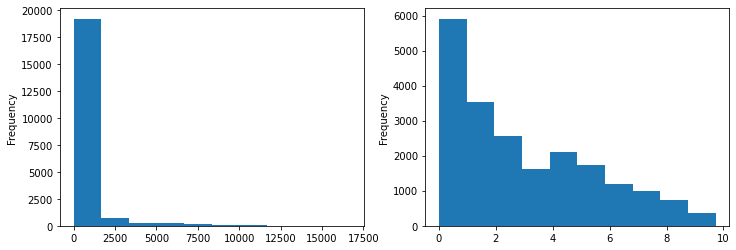

In [3]:
plt.figure(figsize=(12,4)) 

plt.subplot(121)  
df_24h_comar['numOfTaxis_area'].plot.hist()

plt.subplot(122)
df_24h_comar['numOfTaxis_area'] = np.log(df_24h_comar['numOfTaxis_area'])
df_24h_comar['numOfTaxis_area'].plot.hist()
plt.show()

### log on other dfs

In [ ]:
df_24h_hexlow['numOfTaxis_area'] = np.log(df_24h_hexlow['numOfTaxis_area'])
df_24h_hexmed['numOfTaxis_area'] = np.log(df_24h_hexmed['numOfTaxis_area'])
df_24h_hexhig['numOfTaxis_area'] = np.log(df_24h_hexhig['numOfTaxis_area'])

In [6]:
df_24h_comar.drop(columns = ['date_start'],inplace = True)
df_24h_hexlow.drop(columns = ['date_start'],inplace = True)
df_24h_hexmed.drop(columns = ['date_start'],inplace = True)
df_24h_hexhig.drop(columns = ['date_start'],inplace = True)

In [7]:
df_24h_comar = pred.dayandseas_to_int(df_24h_comar)
df_24h_hexlow = pred.dayandseas_to_int(df_24h_hexlow)
df_24h_hexmed = pred.dayandseas_to_int(df_24h_hexmed)
df_24h_hexhig = pred.dayandseas_to_int(df_24h_hexhig)

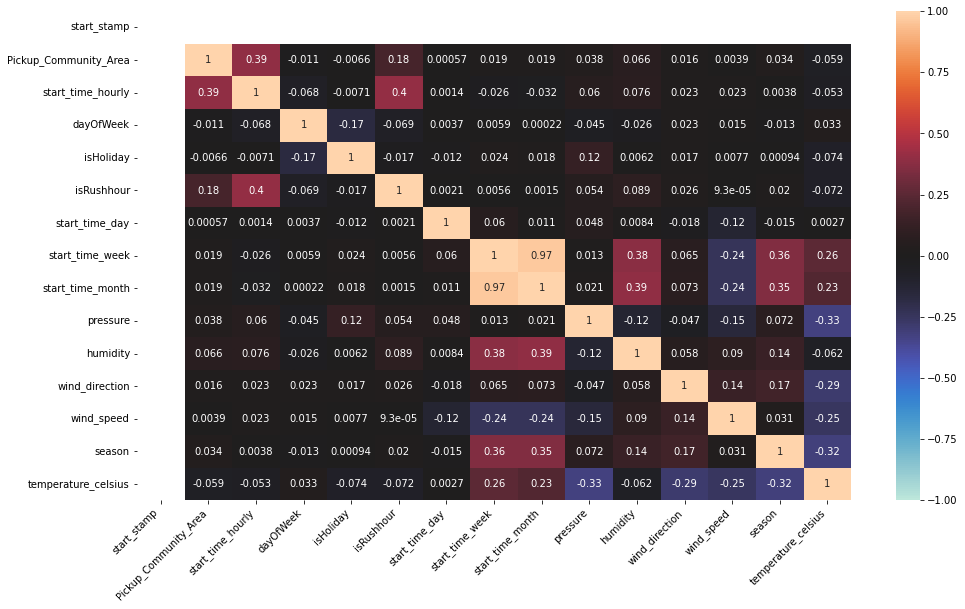

In [8]:
# correlation matrix of df_h_comar

import seaborn as sns
corr = df_24h_comar.drop(columns = ['numOfTaxis_area']).corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

We have a very high correlation between `start_time_month` and `start_time_week`, which leads to dropping `start_time_month`. The correlation matrix shows nothing for `start_stamp`, because for this feature every value is zero. This is beacuse we look at daily data and the column `start_stamp` represents the starting hour of an, here daily, interval. Because `start_stamp` is zero for every row and because we aren't interesetd in `start_time_hourly`, but in the daily demand, we drop both columns:

In [9]:
df_24h_comar.drop(columns = ['start_time_month'],inplace = True)

In [10]:
df_24h_comar.drop(columns = ['start_time_hourly'],inplace = True)

In [11]:
df_24h_comar.drop(columns = ['start_stamp'],inplace = True)

Doing the same for the dataframes of:

- hexagons with low resolution
- hexagons with medium resolution
- hexagons with high resolution

In [13]:
df_24h_hexlow.drop(columns = ['start_time_hourly','start_time_month','start_stamp'],inplace = True)
df_24h_hexmed.drop(columns = ['start_time_hourly','start_time_month','start_stamp'],inplace = True)
df_24h_hexhig.drop(columns = ['start_time_hourly','start_time_month','start_stamp'],inplace = True)

<hr style="border: 1px solid #8888;">

## Daily Demand - Community Area

In [14]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_24h_comar,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [15]:
categoric, numeric = pred.cat_and_num('Pickup_Community_Area')

In [16]:
categoric.remove('start_stamp')

### Building the model: Checking for the best kernel

#### SVR KERNEL: LINEAR

In [17]:
svr_lin = SVR(kernel = 'linear',verbose = 10,cache_size=15000)

In [18]:
pipeline = pred.pipeline_fit_predict(svr_lin, categoric, numeric, x_train, y_train, x_val, y_val,
                               df_24h_comar, 'numOfTaxis_area', if_log = True)

[LibSVM].................................................................................................................................................................*.................................................................................................................................................*.................................................................*...............*
optimization finished, #iter = 385003
obj = -2821.773372, rho = -2.230407
nSV = 8168, nBSV = 7940
MODEL SCORES:
MAE:  94.913
MSE:  125735.879
RMSE:  354.593
Accuracy: 88.26 %
R2:  96.779 %
Max Residual Error:  4468.365


#### SVR KERNEL: POLYNOMIAL WITH DEGREE 2

In [17]:
svr_poly2 = SVR(kernel = 'poly',degree = 2, verbose = 10,cache_size=15000)

In [18]:
pipeline = pred.pipeline_fit_predict(svr_poly2, categoric, numeric, x_train, y_train, x_val, y_val,
                                df_24h_comar, 'numOfTaxis_area', if_log = True)

[LibSVM].....................*...........*
optimization finished, #iter = 32010
obj = -8085.490998, rho = -1.980471
nSV = 11296, nBSV = 9233
MODEL SCORES:
MAE:  108.410
MSE:  189452.053
RMSE:  435.261
Accuracy: 87.31 %
R2:  96.128 %
Max Residual Error:  6177.070


#### SVR KERNEL: POLYNOMIAL WITH DEGREE 3

In [19]:
svr_poly3 = SVR(kernel = 'poly',verbose = 10,cache_size=15000)

In [20]:
pipeline = pred.pipeline_fit_predict(svr_poly3, categoric, numeric, x_train, y_train, x_val, y_val,
                                df_24h_comar, 'numOfTaxis_area', if_log = True)

[LibSVM]..................*.......*
optimization finished, #iter = 25438
obj = -10303.050621, rho = -1.869025
nSV = 12348, nBSV = 8446
MODEL SCORES:
MAE:  269.419
MSE:  2197362.040
RMSE:  1482.350
Accuracy: 81.33 %
R2:  91.960 %
Max Residual Error:  77753.413


#### SVR KERNEL: RBF

In [23]:
svr_rbf = SVR(kernel = 'rbf',verbose = 10,cache_size=15000)

In [24]:
pipeline = pred.pipeline_fit_predict(svr_rbf, categoric, numeric, x_train, y_train, x_val, y_val,
                                df_24h_comar, 'numOfTaxis_area', if_log = True)

[LibSVM].............*.....*
optimization finished, #iter = 18103
obj = -8470.196165, rho = -1.337656
nSV = 11897, nBSV = 8936
MODEL SCORES:
MAE:  186.762
MSE:  634785.908
RMSE:  796.735
Accuracy: 85.24 %
R2:  94.917 %
Max Residual Error:  13423.232


<hr style="border: 0.5px solid #8888;">

### Hyperparameter Tuning for the best model

In [25]:
# creating the ranges for model parameter to use in find_best_hyperparameters

model_para = {'model__C':loguniform(1e-1, 1e2),
              'model__epsilon':loguniform(1e-1, 1e2)}               

In [26]:
svr_lin = SVR(kernel = 'linear',cache_size=15000)

In [27]:
pipeline = pred.pipeline_for_prediction(categoric, numeric, svr_lin)

In [28]:
pred.find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_absolute_error', verbose=10)

Running grid search for the model based on neg_mean_absolute_error
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 1/5; 1/100] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-2.816 total time=   0.0s
[CV 2/5; 1/100] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 2/5; 1/100] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-2.728 total time=   0.0s
[CV 3/5; 1/100] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 3/5; 1/100] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-2.804 total time=   0.0s
[CV 4/5; 1/100] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 4/5; 1/100] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-2.679 total time=   0.0s
[CV 5/5; 1/100] START model__C=1.3292918943162166, model__epsilon=71.1

[CV 3/5; 9/100] END model__C=0.8179499475211672, model__epsilon=3.752055855124281;, score=-2.203 total time=   0.1s
[CV 4/5; 9/100] START model__C=0.8179499475211672, model__epsilon=3.752055855124281
[CV 4/5; 9/100] END model__C=0.8179499475211672, model__epsilon=3.752055855124281;, score=-2.147 total time=   0.1s
[CV 5/5; 9/100] START model__C=0.8179499475211672, model__epsilon=3.752055855124281
[CV 5/5; 9/100] END model__C=0.8179499475211672, model__epsilon=3.752055855124281;, score=-2.201 total time=   0.1s
[CV 1/5; 10/100] START model__C=1.976218934028007, model__epsilon=0.7476312062252299
[CV 1/5; 10/100] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-0.424 total time=   0.6s
[CV 2/5; 10/100] START model__C=1.976218934028007, model__epsilon=0.7476312062252299
[CV 2/5; 10/100] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-0.428 total time=   0.5s
[CV 3/5; 10/100] START model__C=1.976218934028007, model__epsilon=0.747631206225

[CV 1/5; 19/100] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-0.375 total time=   1.1s
[CV 2/5; 19/100] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 2/5; 19/100] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-0.377 total time=   1.0s
[CV 3/5; 19/100] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 3/5; 19/100] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-0.342 total time=   1.0s
[CV 4/5; 19/100] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 4/5; 19/100] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-0.365 total time=   1.1s
[CV 5/5; 19/100] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 5/5; 19/100] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-0.336 total time=   1.1s
[CV 1/5; 20/100] START model__C=11.290133559092672, model__epsilon

[CV 1/5; 28/100] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-2.816 total time=   0.0s
[CV 2/5; 28/100] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 2/5; 28/100] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-2.728 total time=   0.0s
[CV 3/5; 28/100] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 3/5; 28/100] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-2.804 total time=   0.0s
[CV 4/5; 28/100] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 4/5; 28/100] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-2.679 total time=   0.0s
[CV 5/5; 28/100] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 5/5; 28/100] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-2.780 total time=   0.0s
[CV 1/5; 29/100] START model__C=0.18427970406864538, model__epsilon=0.38721

[CV 2/5; 36/100] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-0.381 total time=  11.3s
[CV 3/5; 36/100] START model__C=20.73644517790503, model__epsilon=0.39459088111.
[CV 3/5; 36/100] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-0.354 total time=  10.9s
[CV 4/5; 36/100] START model__C=20.73644517790503, model__epsilon=0.39459088111.
[CV 4/5; 36/100] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-0.373 total time=   9.9s
[CV 5/5; 36/100] START model__C=20.73644517790503, model__epsilon=0.39459088111.
[CV 5/5; 36/100] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-0.347 total time=   9.7s
[CV 1/5; 37/100] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 1/5; 37/100] END model__C=0.10388823104027935, model__epsilon=27.95015916508335;, score=-2.816 total time=   0.0s
[CV 2/5; 37/100] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 2/5; 37/100] EN

[CV 2/5; 45/100] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-1.575 total time=   0.1s
[CV 3/5; 45/100] START model__C=45.88156549160973, model__epsilon=2.610025650613476
[CV 3/5; 45/100] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-1.516 total time=   0.1s
[CV 4/5; 45/100] START model__C=45.88156549160973, model__epsilon=2.610025650613476
[CV 4/5; 45/100] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-1.515 total time=   0.1s
[CV 5/5; 45/100] START model__C=45.88156549160973, model__epsilon=2.610025650613476
[CV 5/5; 45/100] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-1.553 total time=   0.1s
[CV 1/5; 46/100] START model__C=0.22844556850020528, model__epsilon=13.795402040204177
[CV 1/5; 46/100] END model__C=0.22844556850020528, model__epsilon=13.795402040204177;, score=-2.816 total time=   0.0s
[CV 2/5; 46/100] START model__C=0.22844556850020528, model__epsilon=13.7954020

[CV 3/5; 53/100] END model__C=52.80796376895363, model__epsilon=0.5595986878006082;, score=-0.368 total time=  16.0s
[CV 4/5; 53/100] START model__C=52.80796376895363, model__epsilon=0.5595986878006082
[CV 4/5; 53/100] END model__C=52.80796376895363, model__epsilon=0.5595986878006082;, score=-0.385 total time=  16.7s
[CV 5/5; 53/100] START model__C=52.80796376895363, model__epsilon=0.5595986878006082
[CV 5/5; 53/100] END model__C=52.80796376895363, model__epsilon=0.5595986878006082;, score=-0.363 total time=  18.4s
[CV 1/5; 54/100] START model__C=1.7027416886764406, model__epsilon=18.477934173519248
[CV 1/5; 54/100] END model__C=1.7027416886764406, model__epsilon=18.477934173519248;, score=-2.816 total time=   0.0s
[CV 2/5; 54/100] START model__C=1.7027416886764406, model__epsilon=18.477934173519248
[CV 2/5; 54/100] END model__C=1.7027416886764406, model__epsilon=18.477934173519248;, score=-2.728 total time=   0.0s
[CV 3/5; 54/100] START model__C=1.7027416886764406, model__epsilon=18.4

[CV 1/5; 62/100] END model__C=0.8995191735587166, model__epsilon=0.21387290754148916;, score=-0.375 total time=   1.1s
[CV 2/5; 62/100] START model__C=0.8995191735587166, model__epsilon=0.21387290754148916
[CV 2/5; 62/100] END model__C=0.8995191735587166, model__epsilon=0.21387290754148916;, score=-0.377 total time=   1.1s
[CV 3/5; 62/100] START model__C=0.8995191735587166, model__epsilon=0.21387290754148916
[CV 3/5; 62/100] END model__C=0.8995191735587166, model__epsilon=0.21387290754148916;, score=-0.342 total time=   1.1s
[CV 4/5; 62/100] START model__C=0.8995191735587166, model__epsilon=0.21387290754148916
[CV 4/5; 62/100] END model__C=0.8995191735587166, model__epsilon=0.21387290754148916;, score=-0.364 total time=   1.1s
[CV 5/5; 62/100] START model__C=0.8995191735587166, model__epsilon=0.21387290754148916
[CV 5/5; 62/100] END model__C=0.8995191735587166, model__epsilon=0.21387290754148916;, score=-0.338 total time=   1.1s
[CV 1/5; 63/100] START model__C=0.4828424974818325, model

[CV 1/5; 71/100] END model__C=77.15105777813044, model__epsilon=0.569307476764461;, score=-0.388 total time=  25.9s
[CV 2/5; 71/100] START model__C=77.15105777813044, model__epsilon=0.569307476764461
[CV 2/5; 71/100] END model__C=77.15105777813044, model__epsilon=0.569307476764461;, score=-0.395 total time=  31.8s
[CV 3/5; 71/100] START model__C=77.15105777813044, model__epsilon=0.569307476764461
[CV 3/5; 71/100] END model__C=77.15105777813044, model__epsilon=0.569307476764461;, score=-0.369 total time=  31.5s
[CV 4/5; 71/100] START model__C=77.15105777813044, model__epsilon=0.569307476764461
[CV 4/5; 71/100] END model__C=77.15105777813044, model__epsilon=0.569307476764461;, score=-0.385 total time=  25.1s
[CV 5/5; 71/100] START model__C=77.15105777813044, model__epsilon=0.569307476764461
[CV 5/5; 71/100] END model__C=77.15105777813044, model__epsilon=0.569307476764461;, score=-0.365 total time=  32.7s
[CV 1/5; 72/100] START model__C=3.1027409509128394, model__epsilon=0.799162192038435

[CV 2/5; 81/100] END model__C=1.2686721262104845, model__epsilon=7.887102624766473;, score=-2.728 total time=   0.0s
[CV 3/5; 81/100] START model__C=1.2686721262104845, model__epsilon=7.887102624766473
[CV 3/5; 81/100] END model__C=1.2686721262104845, model__epsilon=7.887102624766473;, score=-2.804 total time=   0.0s
[CV 4/5; 81/100] START model__C=1.2686721262104845, model__epsilon=7.887102624766473
[CV 4/5; 81/100] END model__C=1.2686721262104845, model__epsilon=7.887102624766473;, score=-2.679 total time=   0.0s
[CV 5/5; 81/100] START model__C=1.2686721262104845, model__epsilon=7.887102624766473
[CV 5/5; 81/100] END model__C=1.2686721262104845, model__epsilon=7.887102624766473;, score=-2.780 total time=   0.0s
[CV 1/5; 82/100] START model__C=7.954064937683928, model__epsilon=4.0487788181534095
[CV 1/5; 82/100] END model__C=7.954064937683928, model__epsilon=4.0487788181534095;, score=-2.373 total time=   0.1s
[CV 2/5; 82/100] START model__C=7.954064937683928, model__epsilon=4.0487788

[CV 4/5; 89/100] END model__C=11.825328508422647, model__epsilon=1.4461256820152137;, score=-0.741 total time=   0.2s
[CV 5/5; 89/100] START model__C=11.825328508422647, model__epsilon=1.4461256820152137
[CV 5/5; 89/100] END model__C=11.825328508422647, model__epsilon=1.4461256820152137;, score=-0.750 total time=   0.2s
[CV 1/5; 90/100] START model__C=64.59367085984857, model__epsilon=0.25856088907313385
[CV 1/5; 90/100] END model__C=64.59367085984857, model__epsilon=0.25856088907313385;, score=-0.370 total time=  46.7s
[CV 2/5; 90/100] START model__C=64.59367085984857, model__epsilon=0.25856088907313385
[CV 2/5; 90/100] END model__C=64.59367085984857, model__epsilon=0.25856088907313385;, score=-0.377 total time=  43.8s
[CV 3/5; 90/100] START model__C=64.59367085984857, model__epsilon=0.25856088907313385
[CV 3/5; 90/100] END model__C=64.59367085984857, model__epsilon=0.25856088907313385;, score=-0.340 total time=  44.1s
[CV 4/5; 90/100] START model__C=64.59367085984857, model__epsilon=

[CV 1/5; 98/100] END model__C=1.040134192266346, model__epsilon=1.1159088550343401;, score=-0.607 total time=   0.2s
[CV 2/5; 98/100] START model__C=1.040134192266346, model__epsilon=1.1159088550343401
[CV 2/5; 98/100] END model__C=1.040134192266346, model__epsilon=1.1159088550343401;, score=-0.588 total time=   0.2s
[CV 3/5; 98/100] START model__C=1.040134192266346, model__epsilon=1.1159088550343401
[CV 3/5; 98/100] END model__C=1.040134192266346, model__epsilon=1.1159088550343401;, score=-0.580 total time=   0.3s
[CV 4/5; 98/100] START model__C=1.040134192266346, model__epsilon=1.1159088550343401
[CV 4/5; 98/100] END model__C=1.040134192266346, model__epsilon=1.1159088550343401;, score=-0.588 total time=   0.2s
[CV 5/5; 98/100] START model__C=1.040134192266346, model__epsilon=1.1159088550343401
[CV 5/5; 98/100] END model__C=1.040134192266346, model__epsilon=1.1159088550343401;, score=-0.594 total time=   0.2s
[CV 1/5; 99/100] START model__C=15.061458746961156, model__epsilon=49.12819

In [29]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000,epsilon =0.13783237455007183, C= 5.9874749104613985,verbose = 10)

In [30]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                     df_24h_comar, 'numOfTaxis_area', if_log = True)

[LibSVM]..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................*.....................................................................................................................................................................................................................................................

<hr style="border: 0.5px solid #8888;">


## Daily Demand - hexagon low resolution 

In [ ]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_24h_hexlow,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [ ]:
categoric, numeric = pred.cat_and_num('h3_hex_id_low_res')

In [ ]:
categoric.remove('start_stamp')

In [60]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [61]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                      df_24h_hexlow, 'numOfTaxis_area', if_log = True)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -106216334.908176, rho = -31.404760
nSV = 45998, nBSV = 34352


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  49.649
MSE:  19335.192
RMSE:  139.051
Accuracy: 42.61 %
R2:  59.394 %
Max Residual Error:  1997.387


<hr style="border: 0.5px solid #8888;">


## Daily Demand - hexagon medium resolution

In [ ]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_24h_hexmed,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [ ]:
categoric, numeric = pred.cat_and_num('h3_hex_id_medium_res')

In [ ]:
categoric.remove('start_stamp')

In [72]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [73]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                df_24h_hexmed, 'numOfTaxis_area', if_log = True)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -71769692.922822, rho = -9.900635
nSV = 53540, nBSV = 36094


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  21.106
MSE:  3232.545
RMSE:  56.855
Accuracy: 34.96 %
R2:  60.551 %
Max Residual Error:  1298.962


<hr style="border: 0.5px solid #8888;">


## Daily Demand - hexagon high resolution

In [ ]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_24h_hexhig,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [ ]:
categoric, numeric = pred.cat_and_num('h3_hex_id_high_res')

In [ ]:
categoric.remove('start_stamp')

In [78]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [79]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                df_24h_hexhig, 'numOfTaxis_area', if_log = True)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -54172541.831035, rho = -1.700378
nSV = 59016, nBSV = 39918


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  13.751
MSE:  628.844
RMSE:  25.077
Accuracy: 16.63 %
R2:  45.458 %
Max Residual Error:  599.243
